In [2]:
import rawpy
from PIL import Image, ExifTags
from colour_demosaicing import demosaicing_CFA_Bayer_bilinear, demosaicing_CFA_Bayer_Malvar2004, demosaicing_CFA_Bayer_Menon2007
import numpy as np
import matplotlib.pyplot as plt
from photutils.detection import DAOStarFinder
import os
from astropy.io import fits
import pickle as p
from light_frame_processing import *
from photutils.aperture import CircularAperture
from scipy.ndimage import shift

In [3]:
stacked = fits.open('stacked_image.fits')[0].data

FileNotFoundError: [Errno 2] No such file or directory: 'stacked_image.fits'

In [ ]:
plt.imshow(stacked)

In [325]:
dir_path = 'M81+82_052424/'
light_files = [os.path.join(dir_path,f'DSC_{n:04}.NEF') for n in range(78,106)]
light_exp = 150 # exposure time in seconds
flat_exp = 12
dark_exp = 150

In [326]:
light_frames = np.array([rawpy.imread(file).raw_image for file in light_files])


In [327]:
master_bias = fits.open('master_bias.fits')[0].data
master_dark = fits.open('master_dark.fits')[0].data
master_flat = fits.open('master_flat.fits')[0].data

In [328]:
processed_lights = []
for i, frame in enumerate(light_frames):
    frame = frame - master_bias - master_dark*light_exp
    frame /= master_flat
    processed_lights.append(frame)
    # hdu = fits.PrimaryHDU(frame)
    # hdu.writeto(os.path.join('M81_82_052424_proc',f'light_proc_{i:03}.fits'))

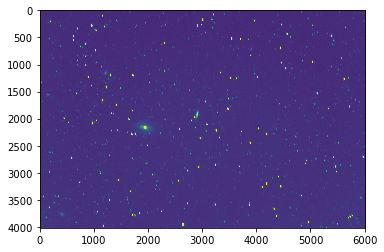

In [6]:
plt.imshow(processed_lights[0], vmin=300, vmax=1200)

In [7]:
rgb_lights = debayer_frames(processed_lights)

Demosaicing...



KeyboardInterrupt



In [43]:
with open('light_frames_sections.p', 'rb') as f:
    rgb_lights = p.load(f)
    

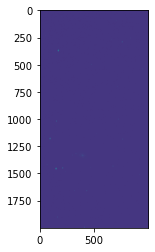

In [44]:
plt.imshow(rgb_lights[10][:,:,2])

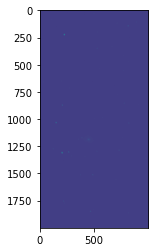

In [45]:
plt.imshow(rgb_lights[2][:,:,2])

In [8]:
len(rgb_lights)

NameError: name 'rgb_lights' is not defined

In [72]:
star_tables = []
for light in rgb_lights:
    f = light[:,:,1]
    finder = DAOStarFinder(12000,10,brightest=3)
    star_tables.append(finder.find_stars(f))

In [7]:
len(processed_lights)

28

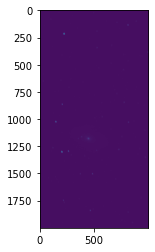

In [47]:
plt.imshow(rgb_lights[1][:,:,1])

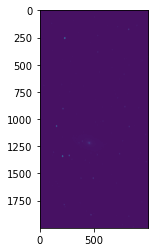

In [48]:
plt.imshow(rgb_lights[5][:,:,1])

In [73]:
star_tables

[<QTable length=3>
   id    xcentroid     ycentroid   ...      flux           mag      
 int64    float64       float64    ...    float64        float64    
 ----- ------------- ------------- ... ------------- ---------------
     1 217.663965263 207.154574269 ...  4.0974209993  -1.53127647217
     2 258.345565069 1282.66121837 ... 1.77739985082 -0.624462848454
     3 200.973581802 853.343734938 ... 1.42651669984 -0.385692150472,
 <QTable length=3>
   id    xcentroid     ycentroid   ...      flux           mag      
 int64    float64       float64    ...    float64        float64    
 ----- ------------- ------------- ... ------------- ---------------
     1 220.728774482  218.47045243 ...  3.9314404928  -1.48637926617
     2 261.730730487 1293.74271797 ... 2.45063964008   -0.9731986353
     3 204.331636356 864.193080709 ... 1.97496017529 -0.738895856456,
 <QTable length=3>
   id    xcentroid     ycentroid   ...      flux          mag      
 int64    float64       float64    ...    flo

/Users/Celloman/miniconda3/lib/python3.9/site-packages/astropy/table/table.py:3474: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


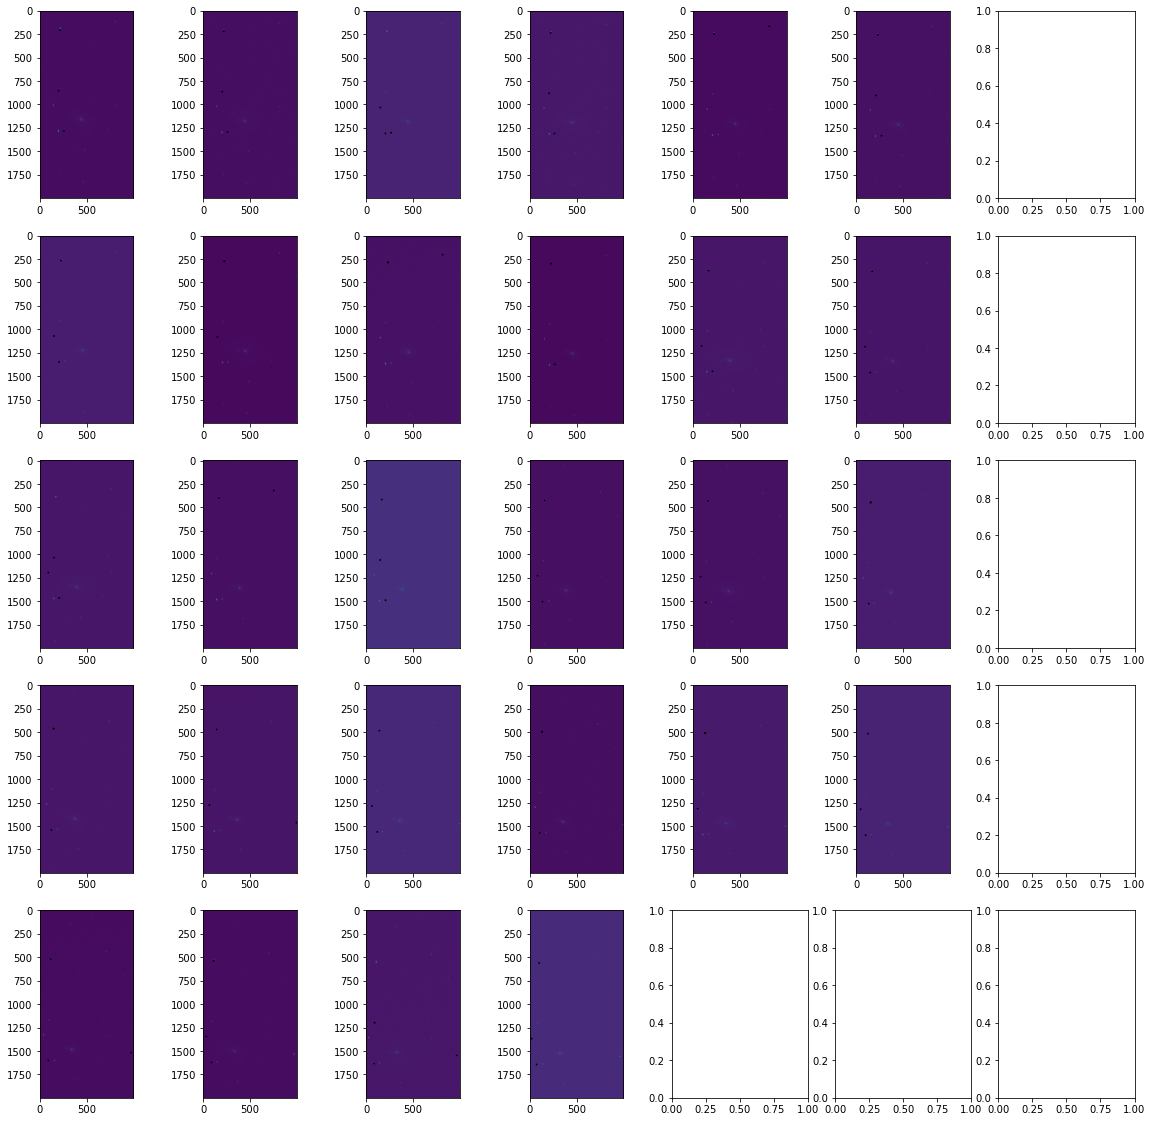

In [74]:
not_aligned = []
n_cols = 6
extra_row = 1 if len(star_tables)%n_cols else 0
fig, ax = plt.subplots(len(star_tables)//n_cols+extra_row, len(star_tables)//(len(star_tables)//n_cols))
fig.set_figheight(20)
fig.set_figwidth(20)
for i, tab in enumerate(star_tables):
    
    if tab != None:
        
        ax[i//n_cols][i%n_cols].imshow(rgb_lights[i][:,:,1])
        for star in tab:
            ap = CircularAperture((star['xcentroid'], star['ycentroid']), 5)
            # print(star['peak'])
            ap.plot(ax=ax[i//n_cols][i%n_cols])
    else:
        not_aligned.append(i)

In [71]:
not_aligned

[0]

In [78]:
dist_map_list = []
for tab in star_tables:
    dist_map = {}
    for i, star in enumerate(tab):
        for star2 in tab[i+1:]:
            dist_map[(star['id'], star2['id'])] = np.sqrt((star['xcentroid'] - star2['xcentroid'])**2 + (star['ycentroid'] - star2['ycentroid'])**2)
    dist_map_list.append(dist_map)

In [86]:
np.round(list(dist_map_list[0].values()),1)

array([ 1076.3,   646.4,   433.1])

In [91]:
ref = 1 # index of reference frame
# for i, d in enumerate(dist_map_list):
d = dist_map_list[ref]
for d2 in dist_map_list:
    for pair in d:
        dist = np.round(d[pair],1)
        for pair2 in d2:
            if np.round(d2[pair2],1) == dist:
                print(f'found pair of pairs: {pair} and {pair2}')
                break
            

found pair of pairs: (1, 2) and (1, 2)
found pair of pairs: (1, 3) and (1, 3)
found pair of pairs: (2, 3) and (2, 3)


In [92]:
ref = 2 # index of reference frame
# for i, d in enumerate(dist_map_list):
d = dist_map_list[ref]
for d2 in dist_map_list:
    for pair in d:
        dist = np.round(d[pair],1)
        for pair2 in d2:
            if np.round(d2[pair2],1) == dist:
                print(f'found pair of pairs: {pair} and {pair2}')
                break
            

found pair of pairs: (1, 2) and (1, 2)
found pair of pairs: (1, 3) and (1, 3)
found pair of pairs: (2, 3) and (2, 3)
found pair of pairs: (1, 2) and (1, 2)


In [133]:
ref = [] # index of reference frame
max_count = 0
matched_dicts = {}

for i, d in enumerate(dist_map_list):
    pair_dict = {}
    match_count = 0
    # d = dist_map_list[ref]
    for j, d2 in enumerate(dist_map_list):
        for pair in d:
            dist = np.round(d[pair],0)
            for pair2 in d2:
                if np.round(d2[pair2],0) == dist:
                    # print(f'found pair of pairs: {pair} and {pair2}')
                    pair_dict[j] = (pair, pair2)
                    match_count+=1
                    break
            if np.round(d2[pair2],0) == dist:
                break
    matched_dicts[i] = pair_dict
    # matched_list.append(pair_dict)
    if match_count > max_count:
        max_count = match_count
        ref = [i]
    elif match_count == max_count:
        ref += [i]
print(f'best ref(s) is/are {ref} with {max_count} counts')

best ref(s) is/are [10, 27] with 12 counts


In [153]:
matched_dicts[10]

{0: ((2, 3), (1, 2)),
 1: ((2, 3), (1, 2)),
 3: ((2, 3), (1, 2)),
 5: ((2, 3), (1, 2)),
 7: ((1, 2), (1, 2)),
 9: ((2, 3), (1, 3)),
 10: ((1, 2), (1, 2)),
 12: ((1, 3), (1, 2)),
 14: ((2, 3), (1, 2)),
 20: ((1, 2), (1, 3)),
 22: ((1, 2), (1, 2)),
 25: ((1, 2), (2, 3))}

In [140]:
matched_dicts[27]

{2: ((1, 2), (1, 2)),
 6: ((1, 2), (1, 2)),
 7: ((1, 3), (1, 3)),
 16: ((2, 3), (2, 3)),
 17: ((2, 3), (1, 3)),
 18: ((2, 3), (2, 3)),
 19: ((1, 3), (1, 2)),
 21: ((2, 3), (1, 2)),
 23: ((1, 2), (1, 2)),
 24: ((2, 3), (1, 2)),
 25: ((1, 2), (1, 3)),
 27: ((1, 2), (1, 2))}

In [267]:
def remove_from_list(l, e):
    if type(e) not in [list, tuple]:
        e = [e]
    new_l = []
    for i in l:
        if i not in e:
            new_l.append(i)
    return new_l

In [150]:
matched_dicts[2][6]

((1, 2), (1, 2))

In [151]:
star_tables[2]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,202.273106859,1308.42886151,0.206010647903,0.686589238602,0.963342762697,169,0.0,14905.9837107,4.07573770129,-1.5255155668
2,147.543615179,1032.29567036,0.333156097539,0.481383353199,0.920203103493,169,0.0,15212.3583091,4.04185457761,-1.51645170981
3,263.410135791,1301.47981543,0.508362837248,0.710337635482,0.762862488852,169,0.0,13327.0513532,2.9557771453,-1.17667921689


In [155]:
star_tables[6]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,152.006767025,1071.28512167,0.330914662248,0.370500481188,0.902370495255,169,0.0,15749.701484,4.3238345496,-1.58967266859
2,206.79659391,1347.53542194,0.217598041072,0.49086193973,0.931935850346,169,0.0,15403.5628091,4.25932332309,-1.573351521
3,226.922910708,265.150051099,0.237955825777,-0.0391081201122,0.590629273797,169,0.0,15729.5292106,4.03247456095,-1.51392909076


In [156]:
def rotateImage(img, angle, pivot):
    padX = [img.shape[1] - pivot[0], pivot[0]]
    padY = [img.shape[0] - pivot[1], pivot[1]]
    imgP = np.pad(img, [padY, padX, [0,0]], 'constant')
    imgR = ndimage.rotate(imgP, angle, reshape=False)
    return imgR[padY[0] : -padY[1], padX[0] : -padX[1]]

In [219]:
shifts = {0: (0,0,0)}
for i in matched_dicts:
    for j in matched_dicts[i]:
        if j not in shifts:
            (a1, b1), (a2, b2) = matched_dicts[i][j]
            a1 = star_tables[i][a1-1]
            b1 = star_tables[i][b1-1]
            a2 = star_tables[j][a2-1]
            b2 = star_tables[j][b2-1]
            if ((a1['flux']/b1['flux']) > 1 and (a2['flux']/b2['flux']) < 1) or ((a1['flux']/b1['flux']) < 1 and (a2['flux']/b2['flux']) > 1): # if a1 matches better with b2 then switch
                a2, b2 = b2, a2
            x_shift, y_shift = (a1['xcentroid'] - a2['xcentroid'], a1['ycentroid'] - a2['ycentroid'])
            star_dist = np.sqrt((a1['xcentroid'] - b1['xcentroid'])**2 + (a1['ycentroid'] - b1['ycentroid'])**2)
            im_dist = np.sqrt((b1['xcentroid'] - b2['xcentroid']+x_shift)**2 + (b1['ycentroid'] - b2['ycentroid']+y_shift)**2)
            rot = np.arcsin(im_dist/star_dist)
            if i in shifts:
                x_shift, y_shift = shifts[i][0]+x_shift, shifts[i][1]+y_shift
            shifts[j] = (x_shift, y_shift, rot)

/var/folders/n8/rxrngb3j14v37ltxb_h1vpg80000gn/T/ipykernel_69482/4038491265.py:15: RuntimeWarning: invalid value encountered in arcsin
  rot = np.arcsin(im_dist/star_dist)


In [273]:
def get_shifty(shift_dict, star_tabs, matches, ref=0):
    assert ref in shift_dict
    for j in matches[ref]:
        print(f'check {j}')
        if j not in shift_dict:
            (a1, b1), (a2, b2) = matches[ref][j]
            a1 = star_tabs[ref][a1-1]
            b1 = star_tabs[ref][b1-1]
            a2 = star_tabs[j][a2-1]
            b2 = star_tabs[j][b2-1]
            if ((a1['flux']/b1['flux']) > 1 and (a2['flux']/b2['flux']) < 1) or ((a1['flux']/b1['flux']) < 1 and (a2['flux']/b2['flux']) > 1): # if a1 matches better with b2 then switch
                a2, b2 = b2, a2
            x_shift, y_shift = (a1['xcentroid'] - a2['xcentroid'], a1['ycentroid'] - a2['ycentroid'])
            star_dist = np.sqrt((a1['xcentroid'] - b1['xcentroid'])**2 + (a1['ycentroid'] - b1['ycentroid'])**2)
            im_dist = np.sqrt((b1['xcentroid'] - b2['xcentroid']+x_shift)**2 + (b1['ycentroid'] - b2['ycentroid']+y_shift)**2)
            rot = np.arcsin(im_dist/star_dist)
            if ref in shift_dict:
                x_shift, y_shift = shift_dict[ref][0]+x_shift, shift_dict[ref][1]+y_shift
            shift_dict[j] = (x_shift, y_shift, rot)
            print(j)
    whats_left = remove_from_list(list(range(len(star_tabs))), list(shift_dict.keys()))
    if whats_left != []:
        for i in shift_dict:
            for j in whats_left:
                if j in matches[i]:  
                    return get_shifty(shift_dict, star_tabs, matches, i)
    return shift_dict

In [271]:
matched_dicts[10]

{0: ((2, 3), (1, 2)),
 1: ((2, 3), (1, 2)),
 3: ((2, 3), (1, 2)),
 5: ((2, 3), (1, 2)),
 7: ((1, 2), (1, 2)),
 9: ((2, 3), (1, 3)),
 10: ((1, 2), (1, 2)),
 12: ((1, 3), (1, 2)),
 14: ((2, 3), (1, 2)),
 20: ((1, 2), (1, 3)),
 22: ((1, 2), (1, 2)),
 25: ((1, 2), (2, 3))}

In [274]:
shifts = {10:(0,0,0)}
shifts = get_shifty(shifts,star_tables, matched_dicts, 10)

check 0
0
check 1
1
check 3
3
check 5
5
check 7
7
check 9
9
check 10
check 12
12
check 14
14
check 20
20
check 22
22
check 25
25
check 7
check 9
check 10
check 19
19
check 20
check 22
check 25
check 27
27
check 7
check 10
check 11
11
check 15
15
check 16
16
check 20
check 22
check 25
check 7
check 8
8
check 10
check 18
18
check 20
check 21
21
check 22
check 25
check 2
2
check 6
6
check 7
check 10
check 20
check 22
check 23
23
check 25
check 27
check 2
check 6
check 7
check 16
check 17
17
check 18
check 19
check 21
check 23
check 24
24
check 25
check 27
check 4
4
check 8
check 18
check 21
check 22


/var/folders/n8/rxrngb3j14v37ltxb_h1vpg80000gn/T/ipykernel_69482/2614935045.py:16: RuntimeWarning: invalid value encountered in arcsin
  rot = np.arcsin(im_dist/star_dist)


In [277]:
shifts

{10: (0, 0, 0),
 0: (-50.05513354508065, 164.94012976989796, 0.32633195757538941),
 1: (-53.119942763995226, 153.62425160871172, 0.30746494060630941),
 3: (-57.324081337715512, 136.59643545913065, 0.27971481394026954),
 5: (-59.295112500335108, 113.99075089890835, 0.24169768352444368),
 7: (-60.053180226299162, 98.341596507983922, 0.28844164957601015),
 9: (-59.686463836056362, 74.110152756944615, 0.1782493251748099),
 12: (0.13573181242296073, -17.50480810983936, 0.11932825890557508),
 14: (3.0200346446394519, -43.191323715440205, 0.080115469311244164),
 20: (32.105052077727009, -108.7529239908356, 0.28345402049520424),
 22: (41.69599783722866, -135.99914334867435, 0.35873207387304162),
 25: (-21.131693564774977, 638.92807033412271, 0.44940993457839495),
 19: (26.549664799865198, -98.215827748200354, 0.55678103688094405),
 27: (71.066814387207927, -189.80465310296199, 0.89218917750137339),
 11: (-0.32645881518268993, -8.2526381887282696, 0.85009998647918805),
 15: (7.4554807030646657,

13, 26

In [280]:
matched_dicts[13]

{13: ((1, 2), (1, 2))}

In [265]:
shifts

{10: (0, 0, 0),
 0: (-142.62695929959395, 1436.9466731022137, 0.79596800551884062),
 1: (-199.51316320563231, 1149.203299266517, nan),
 3: (-203.7173017793526, 1132.175483116936, nan),
 5: (-205.68833294197219, 1109.5697985567135, nan),
 9: (-206.07968427769345, 1069.6892004147498, nan),
 7: (-206.29308739812549, 1093.7250273432692, nan),
 19: (-44.517149587342729, 91.588825354761639, 0.25273525166261535),
 27: (0.0, 0.0, nan),
 2: (-181.0574955824884, 59.24489018926829, nan),
 6: (-311.84865133136611, 355.63352021948845, nan),
 11: (-383.24192453375673, 537.18553513372217, 0.49736842853242735),
 15: (-446.85325821790002, 675.69909989741132, nan),
 16: (-505.74844434193534, 804.3986011794052, nan),
 17: (-561.55804791385185, 921.29155923706048, 0.23968325023452436),
 18: (-666.27936153486064, 746.94310601504549, 0.2098735246550722),
 8: (-873.05590880832005, 1827.5175401386002, nan),
 4: (-1078.6797864028681, 2947.1593572268689, nan)}

/Users/Celloman/miniconda3/lib/python3.9/site-packages/astropy/table/table.py:3474: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


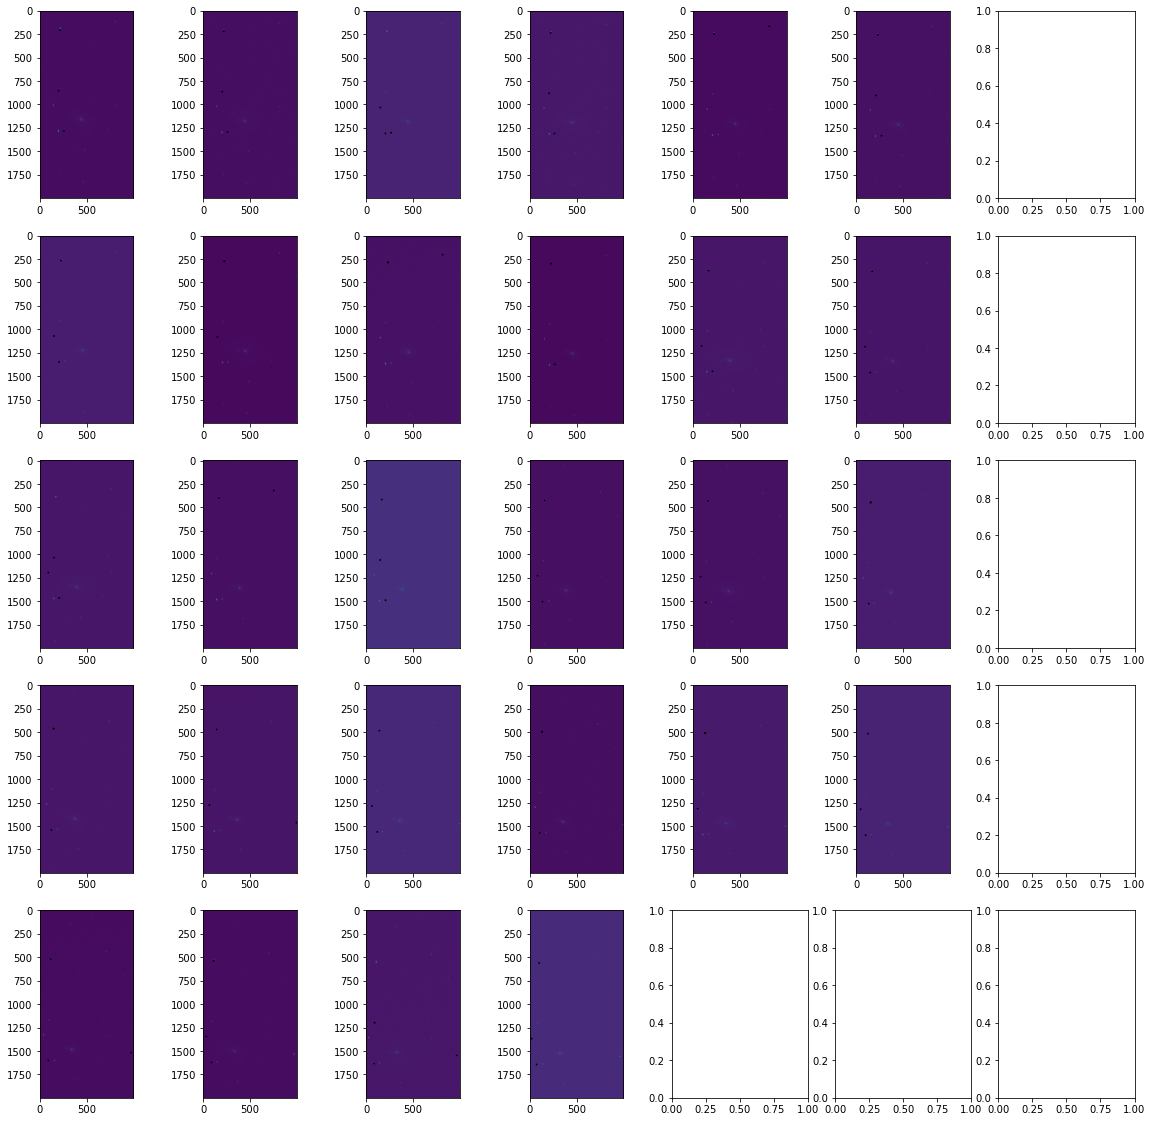

In [74]:
not_aligned = []
n_cols = 6
extra_row = 1 if len(star_tables)%n_cols else 0
fig, ax = plt.subplots(len(star_tables)//n_cols+extra_row, len(star_tables)//(len(star_tables)//n_cols))
fig.set_figheight(20)
fig.set_figwidth(20)
for i, tab in enumerate(star_tables):
    
    if tab != None:
        
        ax[i//n_cols][i%n_cols].imshow(rgb_lights[i][:,:,1])
        for star in tab:
            ap = CircularAperture((star['xcentroid'], star['ycentroid']), 5)
            # print(star['peak'])
            ap.plot(ax=ax[i//n_cols][i%n_cols])
    else:
        not_aligned.append(i)

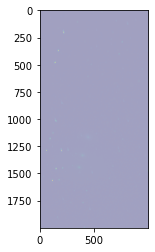

In [178]:
for i in shifts:
    if i % 10 == 0:
        shifted_im = shift(rgb_lights[i], (shifts[i][1], shifts[i][0], 0))
        # plt.imshow(shifted_im[:,:,1], alpha=0.2, vmax=10000)
        plt.imshow(rgb_lights[i][:,:,1], alpha=0.2, vmax=10000)

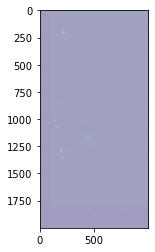

In [179]:
for i in shifts:
    if i % 10 == 0:
        shifted_im = shift(rgb_lights[i], (shifts[i][1], shifts[i][0], 0))
        plt.imshow(shifted_im[:,:,1], alpha=0.2, vmax=10000)

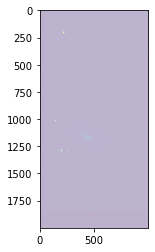

In [182]:
i = 0
shifted_im = shift(rgb_lights[i], (shifts[i][1], shifts[i][0], 0))
plt.imshow(shifted_im[:,:,1], alpha=0.2, vmax=10000)
j = 10
shifted_im = shift(rgb_lights[j], (shifts[j][1], shifts[j][0], 0))
plt.imshow(shifted_im[:,:,1], alpha=0.2, vmax=10000)

In [288]:
def overlay_images(idxs=None, shifted=True, ax=None):
    if ax == None:
        fig, ax = plt.subplots()
    if idxs == None:
        idxs = list(range(28))
    for i in range(28):
        if i in idxs:
            if shifted:
                shifted_im = shift(rgb_lights[i], (shifts[i][1], shifts[i][0], 0))
                ax.imshow(shifted_im[:,:,1], alpha=1/len(idxs), vmax=10000)
            else:
                ax.imshow(rgb_lights[i][:,:,1], alpha=1/len(idxs), vmax=10000)

In [221]:
shifts

{0: (0, 0, 0),
 1: (-3.0648092189145757, -11.315878161186248, 0.021657490781013117),
 3: (-7.2689477926348616, -28.343694310767319, 0.053627895712034843),
 5: (-9.2399789552544576, -50.949378870989619, 0.096380179906216543),
 9: (-9.6313302909757113, -90.82997701295335, 0.17045091016963176),
 10: (50.05513354508065, -164.94012976989796, 0.32640215334902584),
 12: (50.696218296762368, -182.63344281579066, 1.0637376478163756),
 14: (53.075168189720102, -208.13145348533817, 0.41062531783749701),
 2: (0.0, 0.0, 0.0),
 6: (50.266339833610658, 237.14373984095187, 0.28301737756508338),
 23: (158.08783591335472, -11.462788346604611, nan),
 25: (113.83294362108336, -312.81584994344598, nan),
 27: (181.0574955824884, -59.24489018926829, nan),
 4: (0.0, 0.0, 0.0),
 8: (-1.1526696789115363, -39.067382964714, 0.13129739795094506),
 11: (109.66422238009778, 122.30712472496543, 0.32476878572815376),
 15: (117.44616189834514, 79.268674574420857, 0.43711207337667873),
 7: (0.0, 0.0, 0.0),
 19: (86.6028

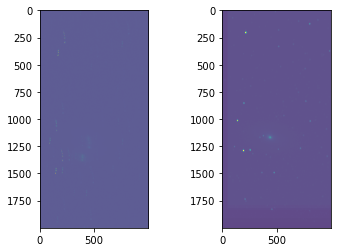

In [222]:
fig, ax = plt.subplots(1,2)
overlay_images([0,1,3,5,9,10,12,14], False, ax[0])
overlay_images([0,1,3,5,9,10,12,14], True, ax[1])


In [208]:
matched_dicts[2]

{2: ((1, 2), (1, 2)),
 6: ((1, 2), (1, 2)),
 23: ((1, 2), (1, 2)),
 25: ((1, 2), (1, 3)),
 27: ((1, 2), (1, 2))}

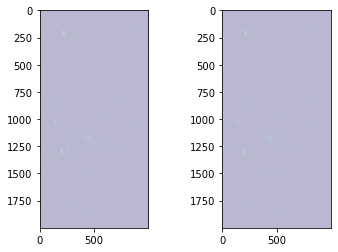

In [229]:
fig, ax = plt.subplots(1,2)
overlay_images([0,2], False, ax[0])
overlay_images([0,2], True, ax[1])

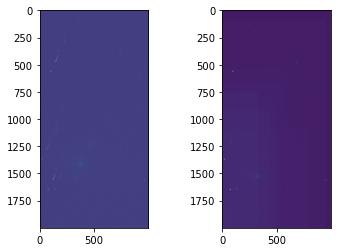

In [266]:
fig, ax = plt.subplots(1,2)
overlay_images([10, 0, 1, 3, 5, 9, 7, 19, 27, 2, 6, 11, 15, 16, 17, 18, 8, 4], False, ax[0])
overlay_images([10, 0, 1, 3, 5, 9, 7, 19, 27, 2, 6, 11, 15, 16, 17, 18, 8, 4], True, ax[1])

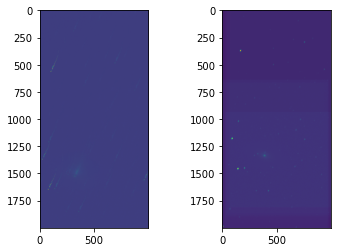

In [283]:
fig, ax = plt.subplots(1,2)
overlay_images(list(shifts.keys()), False, ax[0])
overlay_images(list(shifts.keys()), True, ax[1])

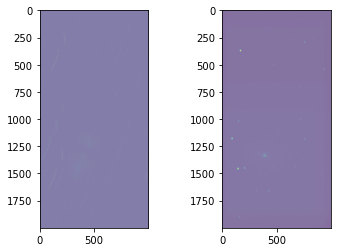

In [290]:
fig, ax = plt.subplots(1,2)
overlay_images(list(shifts.keys()), False, ax[0])
overlay_images(list(shifts.keys()), True, ax[1])

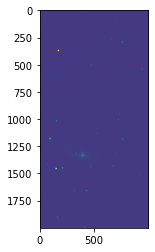

In [291]:
overlay_images([10], False)


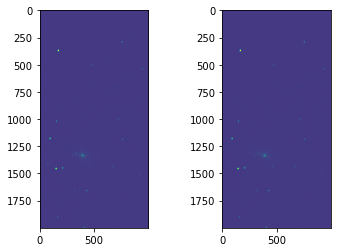

In [293]:
fig, ax = plt.subplots(1,2)
l = [10,]
overlay_images(l, False, ax[0])
overlay_images(l, True, ax[1])


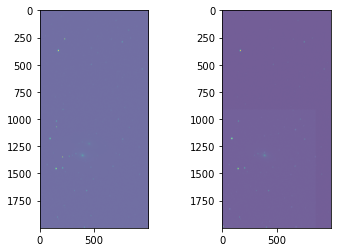

In [303]:
l = [10,6]
fig, ax = plt.subplots(1,2)
overlay_images(l, False, ax[0])
overlay_images(l, True, ax[1])

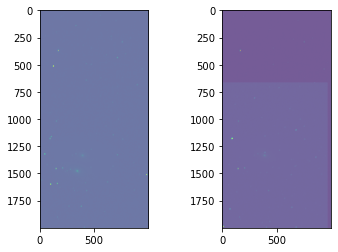

In [320]:
l = [10,23]
fig, ax = plt.subplots(1,2)
overlay_images(l, False, ax[0])
overlay_images(l, True, ax[1])

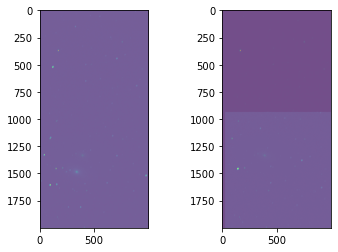

In [322]:
l = [10,24]
fig, ax = plt.subplots(1,2)
overlay_images(l, False, ax[0])
overlay_images(l, True, ax[1])

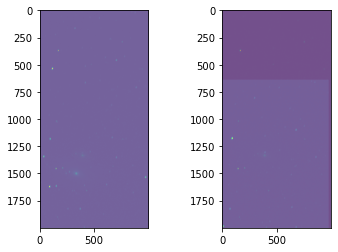

In [323]:
l = [10,25]
fig, ax = plt.subplots(1,2)
overlay_images(l, False, ax[0])
overlay_images(l, True, ax[1])

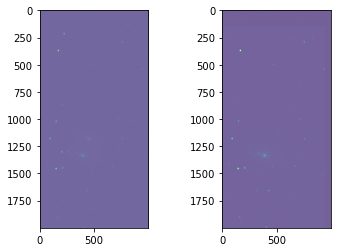

In [324]:
l = [10,1]
fig, ax = plt.subplots(1,2)
overlay_images(l, False, ax[0])
overlay_images(l, True, ax[1])

In [ ]:
idxs = remove_from_list(list(range(28)), [13,26])
shifted_lights = [shift(processed_lights[i], (shifts[i][1], shifts[i][0])) for i in idxs]